In [10]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/01_Strains_AMLNtoControl_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Process for motif calling with Homer

For motif calling its unclear whether it would be ideal to take all peaks activated in C57 compared to any other strain and look for motif enrichment or whether it would be better to look at motifs only in a pairwise fashion. I probably lean towards looking at any peak activated in C57 since they should be enriched for strain specific motifs.

In [12]:
if not os.path.isdir('./motif_calling/'):
    os.mkdir('./motif_calling/')

# Aggregate results - Homer

In [13]:
glob.glob('./motif_calling/*motifs/knownResults.txt')

['./motif_calling/C57_act_peaks_p_0.05_log2fc_1_motifs/knownResults.txt',
 './motif_calling/C57_act_distal_peaks_p_0.05_log2fc_1_motifs/knownResults.txt',
 './motif_calling/aj_act_peaks_p_0.05_log2fc_1_marge_motifs/knownResults.txt',
 './motif_calling/balbc_act_peaks_p_0.05_log2fc_1_marge_motifs/knownResults.txt',
 './motif_calling/balbc_act_distal_peaks_p_0.05_log2fc_1_marge_motifs/knownResults.txt',
 './motif_calling/C57_rep_peaks_p_0.05_log2fc_1_motifs/knownResults.txt',
 './motif_calling/balbc_rep_peaks_p_0.05_log2fc_1_marge_motifs/knownResults.txt',
 './motif_calling/aj_rep_peaks_p_0.05_log2fc_1_marge_motifs/knownResults.txt',
 './motif_calling/C57_rep_distal_peaks_p_0.05_log2fc_1_motifs/knownResults.txt',
 './motif_calling/balbc_rep_distal_peaks_p_0.05_log2fc_1_marge_motifs/knownResults.txt',
 './motif_calling/aj_rep_distal_peaks_p_0.05_log2fc_1_marge_motifs/knownResults.txt',
 './motif_calling/aj_act_distal_peaks_p_0.05_log2fc_1_marge_motifs/knownResults.txt']

In [14]:
known_motif_pval_dict = {}
for f in glob.glob('./motif_calling/*distal*motifs/knownResults.txt'):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_distal_log.txt', sep='\t')

In [15]:
known_motif_pval_frame

,C57_act_distal_peaks_p_0.05_log2fc_1_motifs,balbc_act_distal_peaks_p_0.05_log2fc_1_marge_motifs,C57_rep_distal_peaks_p_0.05_log2fc_1_motifs,balbc_rep_distal_peaks_p_0.05_log2fc_1_marge_motifs,aj_rep_distal_peaks_p_0.05_log2fc_1_marge_motifs,aj_act_distal_peaks_p_0.05_log2fc_1_marge_motifs
Atf3(bZIP)/GBM-ATF3-ChIP-Seq(GSE33912)/Homer,-187.000000,-1.65800,-0.00000,-2.691000,-0.010460,-72.650000
Fra1(bZIP)/BT549-Fra1-ChIP-Seq(GSE46166)/Homer,-182.100000,-1.17400,-0.00000,-2.036000,-0.016340,-71.410000
BATF(bZIP)/Th17-BATF-ChIP-Seq(GSE39756)/Homer,-175.200000,-1.33600,-0.00000,-1.574000,-0.011250,-71.710000
Fra2(bZIP)/Striatum-Fra2-ChIP-Seq(GSE43429)/Homer,-173.200000,-1.55400,-0.00000,-1.734000,-0.038410,-68.070000
JunB(bZIP)/DendriticCells-Junb-ChIP-Seq(GSE36099)/Homer,-165.800000,-1.94000,-0.00000,-2.578000,-0.037370,-70.750000
...,...,...,...,...,...,...
PU.1:IRF8(ETS:IRF)/pDC-Irf8-ChIP-Seq(GSE66899)/Homer,-0.000062,-0.29980,-0.02284,-0.018860,-0.001155,-0.000379
BORIS(Zf)/K562-CTCFL-ChIP-Seq(GSE32465)/Homer,0.000000,-0.06649,-0.00000,-0.007276,-0.000016,0.000000
"Pax7(Paired,Homeobox),long/Myoblast-Pax7-ChIP-Seq(GSE25064)/Homer",-0.069710,0.00000,0.00000,0.000000,0.000000,0.000000
CTCF(Zf)/CD4+-CTCF-ChIP-Seq(Barski_et_al.)/Homer,0.000000,-0.02096,-0.00000,-0.021360,-0.000024,0.000000


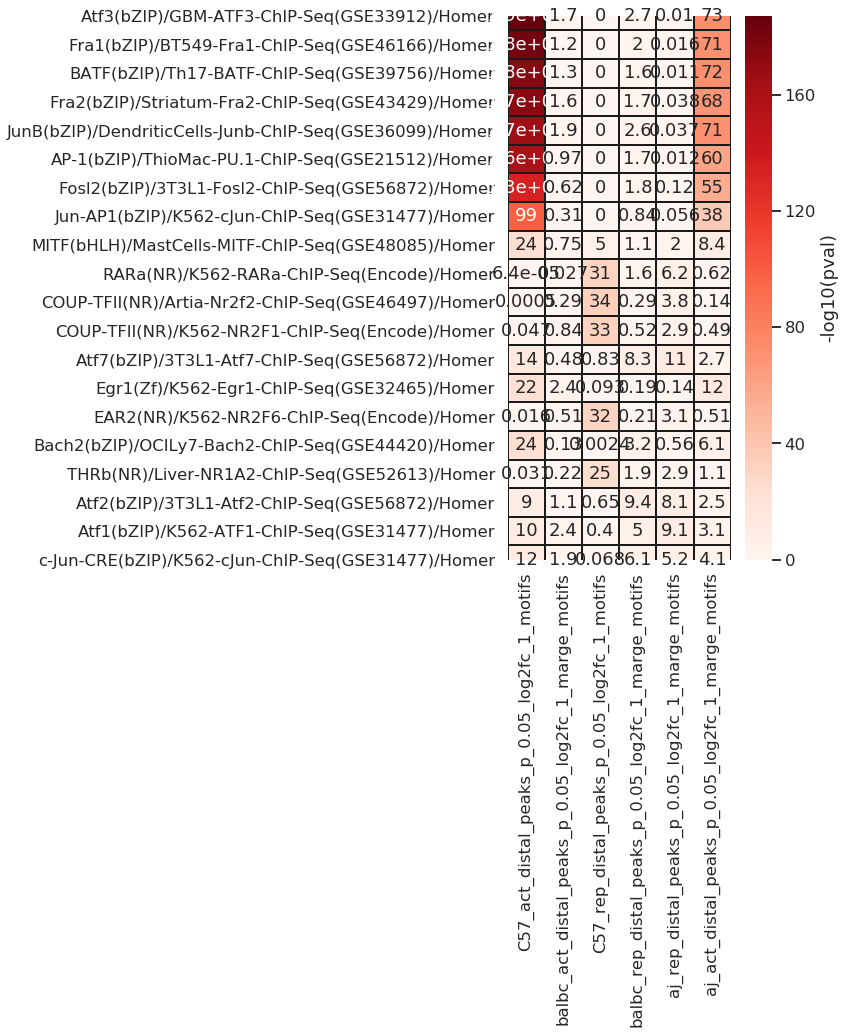

In [16]:
fig, ax = plt.subplots(figsize=(5,10))

sns.heatmap(
    -known_motif_pval_frame.loc[(known_motif_pval_frame <=np.log10(0.00001)).any(axis=1), :].head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    # center=0,
    ax=ax)

# Aggregate results - maggie

All enhancers

In [17]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*/maggie_output_merged.tsv'):
    if 'balbc_aj' not in f:
        # read in signifance values using pandas
        frame = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        # frame = frame[~frame.index.duplicated(keep='first')]
        pval = frame.loc[:, 'Median p-val']

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-2
filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
# filtered_frame = filtered_frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

Plot top 30 motifs upregulated

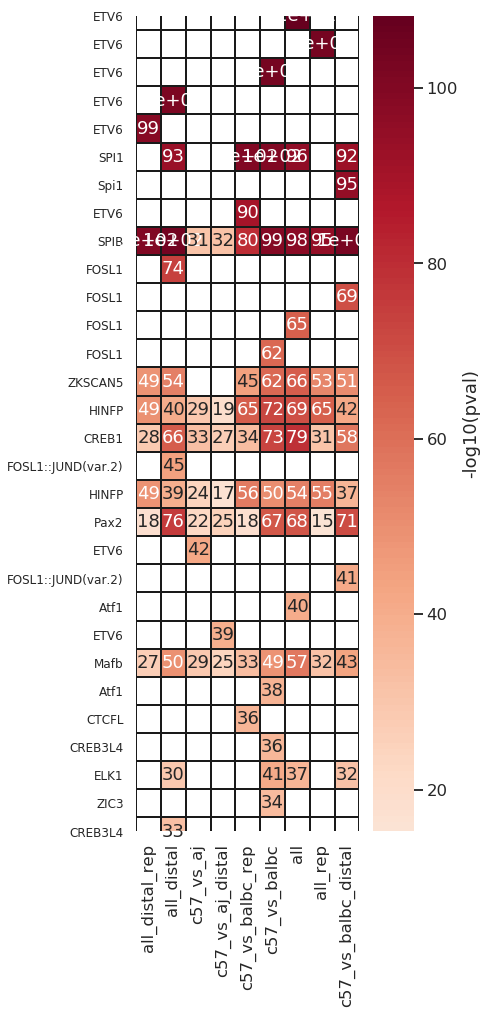

In [18]:
fig, ax = plt.subplots(figsize=(5,15))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) > 0), :].iloc[:30, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=filtered_frame.loc[(filtered_frame.mean(1) > 0), :].index.values, rotation=0);

plt.savefig('./figures/maggie_activated_motifs_merged.png', bbox_inches='tight')

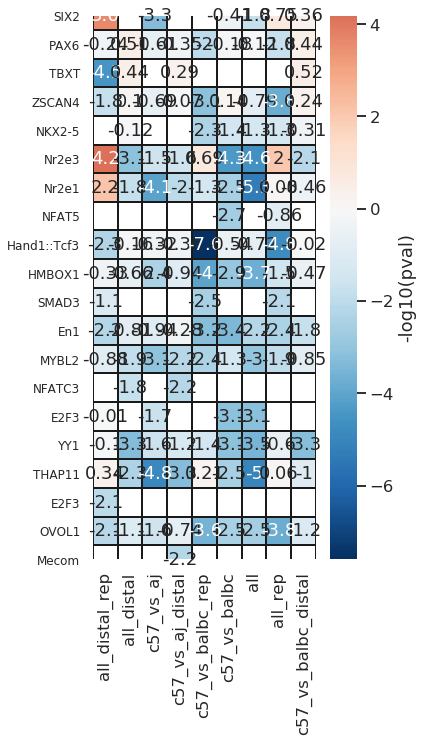

In [19]:
fig, ax = plt.subplots(figsize=(5,10))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) < 0), :].iloc[:20, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12,
                   labels=filtered_frame.loc[(filtered_frame.mean(1) < 0), :].index.values,
                   rotation=0);

plt.savefig('./figures/maggie_repressing_motifs_merged.png', bbox_inches='tight')

### Distal enhancers

In [20]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*distal/maggie_output_merged.tsv'):
    if 'balbc_aj' not in f:
        # read in signifance values using pandas
        frame = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        # frame = frame[~frame.index.duplicated(keep='first')]
        pval = frame.loc[:, 'Median p-val']

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-2
# filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
filtered_frame = frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

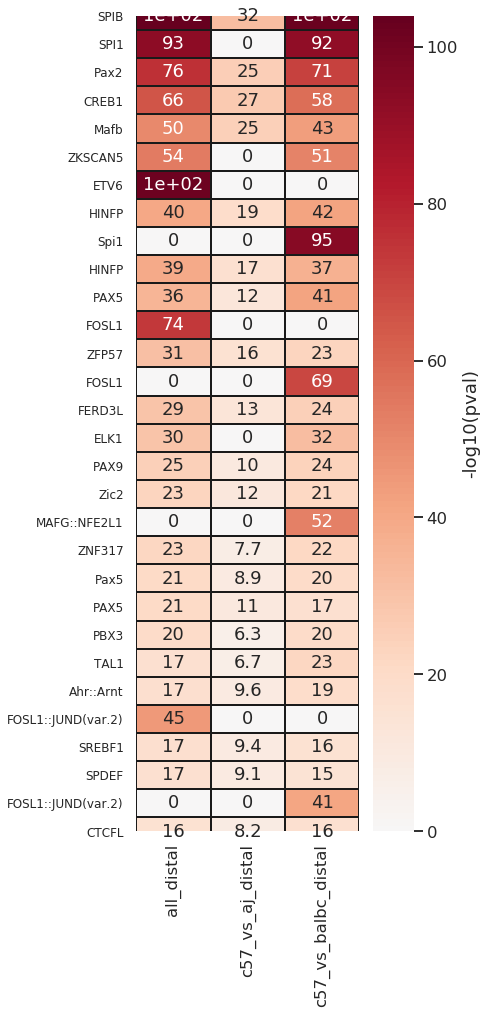

In [21]:
fig, ax = plt.subplots(figsize=(5,15))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) > 0), :].iloc[:30, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_activated_motifs_merged.png', bbox_inches='tight')

In [22]:
filtered_frame

,all_distal,c57_vs_aj_distal,c57_vs_balbc_distal
SPIB,103.89,31.86,102.59
SPI1,93.25,0.00,92.43
Pax2,75.80,25.18,70.66
CREB1,65.50,27.04,57.90
Mafb,49.77,24.61,43.47
...,...,...,...
Hmx3,-22.16,-9.34,-22.27
LIN54,-30.67,-13.72,-30.82
BARX2,-33.57,-13.88,-35.58
FOXL1,-36.32,-13.35,-36.11


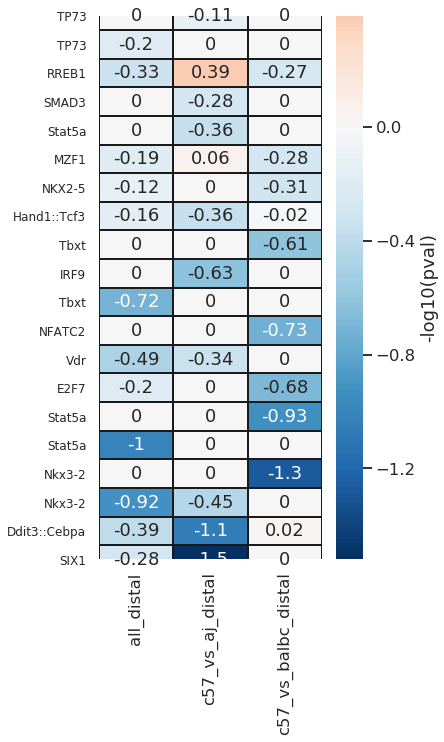

In [23]:
fig, ax = plt.subplots(figsize=(5,10))

hm = sns.heatmap(
    filtered_frame.loc[(filtered_frame.mean(1) < 0), :].iloc[:20, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

hm.set_yticklabels(size=12, labels=filtered_frame.loc[(filtered_frame.mean(1) < 0), :].index.values, rotation=0);

plt.savefig('./figures/maggie_distal_repressed_motifs_merged.png', bbox_inches='tight')

### Plot with just the top motifs from c57_vs_all 

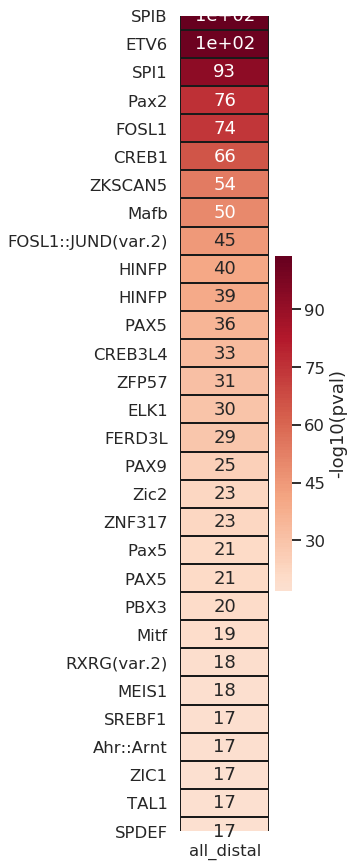

In [24]:
fig, ax = plt.subplots(figsize=(2,15))

filtered_frame = filtered_frame.sort_values('all_distal', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, ['all_distal']].iloc[:30, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_activated_motifs_merged_all.png', bbox_inches='tight')

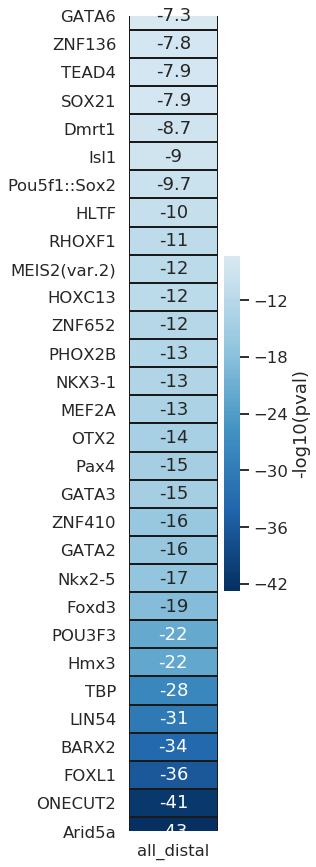

In [25]:
fig, ax = plt.subplots(figsize=(2,15))

filtered_frame = filtered_frame.sort_values('all_distal', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, ['all_distal']].tail(30),
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_repressed_motifs_merged_all.png', bbox_inches='tight')

# Repeat with custom TFs

In [26]:
custom_tfs = ['SPIB', 'ETV6', 'SPI1', 'FOSL1', 'FOSL1::JUND(var.2)',
              'Mitf', 'RXRG(var.2)', 'SREBF1', 'NRF1', 'ATF4']

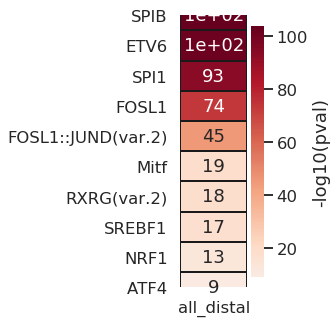

In [27]:
fig, ax = plt.subplots(figsize=(1.5,5))

tmp_frame = filtered_frame.sort_values('all_distal', ascending=False).iloc[:50, :]

hm = sns.heatmap(
    tmp_frame.loc[custom_tfs, ['all_distal']].iloc[:30, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_activated_motifs_merged_custom_tfs.pdf', bbox_inches='tight')

# Repressed enhancers

In [29]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*rep*/maggie_output_merged.tsv'):
    if 'balbc_aj' not in f:
        # read in signifance values using pandas
        frame = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        # frame = frame[~frame.index.duplicated(keep='first')]
        pval = frame.loc[:, 'Median p-val']

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-2
# filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
filtered_frame = frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

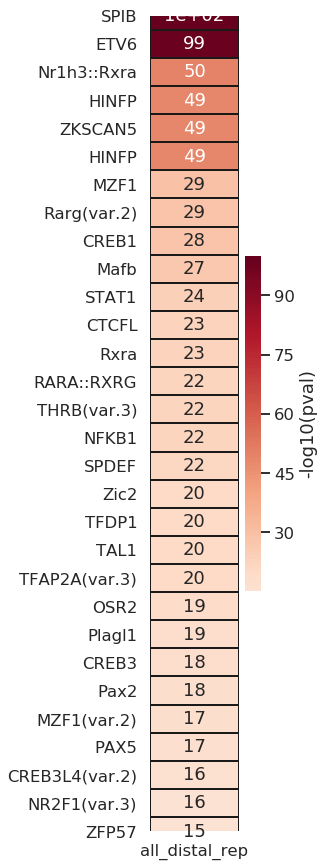

In [30]:
fig, ax = plt.subplots(figsize=(2,15))

filtered_frame = filtered_frame.sort_values('all_distal_rep', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, ['all_distal_rep']].iloc[:30, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

# hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

plt.savefig('./figures/maggie_distal_repressed_motifs_merged_all.png', bbox_inches='tight')

### Plot both repressed activated enhancers.

In [31]:
glob.glob('./maggie_output/all_dista*/maggie_output_merged.tsv')

['./maggie_output/all_distal_rep/maggie_output_merged.tsv',
 './maggie_output/all_distal/maggie_output_merged.tsv']

In [32]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/all_dista*/maggie_output_merged.tsv'):
    if 'balbc_aj' not in f:
        # read in signifance values using pandas
        frame = pd.read_csv(f, sep='\t', index_col=0)

        # remove duplicates
        # frame = frame[~frame.index.duplicated(keep='first')]
        pval = frame.loc[:, 'Median p-val']

        # extract name of sample
        sample = f.split('/')[2]

        # store in dict
        maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-2
# filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
filtered_frame = frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

In [33]:
top_motifs = []
top_n = 15

for col in filtered_frame.columns:
    top_motifs.extend(filtered_frame.sort_values(col, ascending=False).index.tolist()[:top_n])
    
top_motifs = set(top_motifs)

In [34]:
filtered_frame

,all_distal_rep,all_distal
SPIB,100.00,103.89
ZKSCAN5,48.65,54.16
ETV6,0.00,101.79
ETV6,98.56,0.00
CREB1,28.28,65.50
...,...,...
ZEB1,-42.33,0.00
BARX2,-14.16,-33.57
LIN54,-19.03,-30.67
Arid5a,-16.26,-42.73


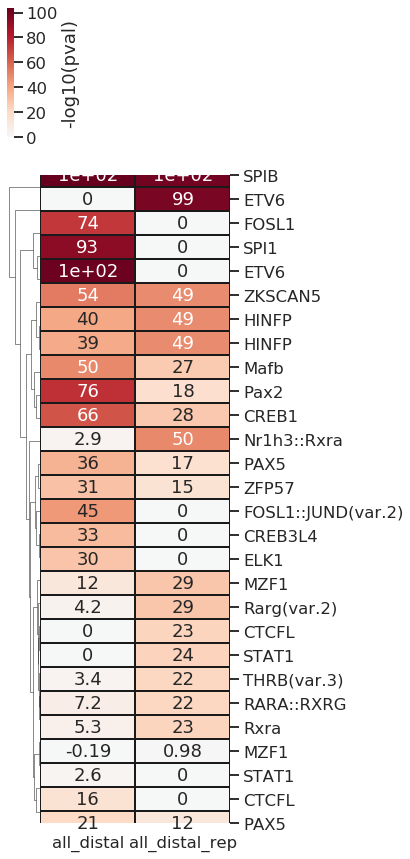

In [47]:

# filtered_frame = filtered_frame.sort_values('all_distal_rep', ascending=False)

cm = sns.clustermap(
    filtered_frame.loc[top_motifs, ['all_distal', 'all_distal_rep']],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    col_cluster=False,
    center=0,
    figsize=(4,15))

# hm.set_yticklabels(size=12, labels=filtered_frame.index.values, rotation=0);

# plt.savefig('./figures/maggie_distal_repressed_motifs_merged_all.png', bbox_inches='tight')

In [36]:
custom_tfs = ['SPIB', 'ETV6', 'SPI1', 'FOSL1', 'FOSL1::JUND(var.2)',
              'Mitf', 'RXRG(var.2)', 'SREBF1', 'NRF1', 'ATF4', 'MZF1',
              'STAT1', 'Rxra', 'RARA::RXRG', 'CTCFL', 'Nr1h3::Rxra',
              'ELK1']

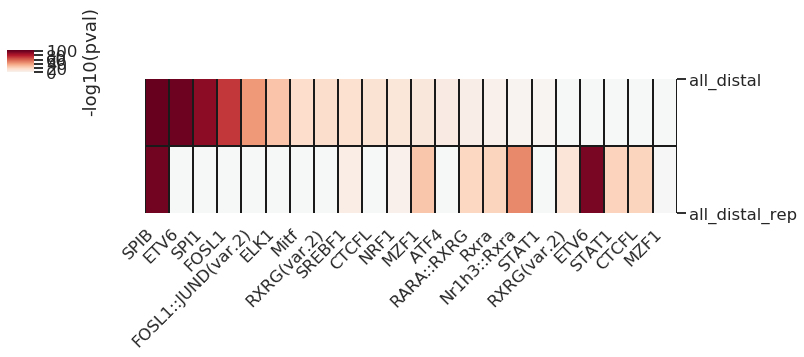

In [71]:
cm = sns.clustermap(
    filtered_frame.loc[custom_tfs, ['all_distal', 'all_distal_rep']].sort_values('all_distal', ascending=False).T,
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    #annot=True,
    #annot_kws={'rotation': 'horizontal',
    #           'position': (0, -10)},
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    row_cluster=False,
    center=0,
    figsize=(12,3))

plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

plt.savefig('./figures/maggie_distal_active_repressed_select_tfs.pdf', bbox_inches='tight')

# repeat with  unmerged motifs

In [2]:
# maggie_merged_pval_dict = {}
# for f in glob.glob('./maggie_output/*c57*200bp/maggie_output.tsv'):
#     if 'balbc_aj' not in f:
#         # read in signifance values using pandas
#         df = pd.read_csv(f, sep='\t', index_col=0)

#         # remove duplicates
#         # frame = frame[~frame.index.duplicated(keep='first')]
#         pval = df.loc[:, 'Median p-val']

#         # extract name of sample
#         sample = f.split('/')[2]

#         # store in dict
#         maggie_merged_pval_dict[sample] = pval    
    
# # create data frame
# maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# # sort by average p value
# maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

# maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# # filter for plotting
# frame = maggie_merged_pval_frame

# # select only samples with pval < 10-10
# filtered_frame = frame.loc[(np.abs(frame) > 20).any(1), :]

# # replace NaN with 0
# filtered_frame = filtered_frame.replace(np.nan, 0)

# # sort
# filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

In [3]:
# fig, ax = plt.subplots(figsize=(5,20))

# hm = sns.heatmap(
#     filtered_frame.loc[(filtered_frame.mean(1)) > 0, :].head(40),
#     cmap='RdBu_r',
#     linewidths=1,
#     linecolor='k',
#     annot=True,
#     cbar_kws={'label': '-log10(pval)'},
#     # square=True,
#     center=0,
#     ax=ax)

# hm.set_yticklabels(size=12, labels=df.loc[filtered_frame.index.values,'motif'], rotation=0);

# plt.savefig('./figures/maggie_activated_motifs.png', bbox_inches='tight')

In [4]:
# fig, ax = plt.subplots(figsize=(5,20))

# hm = sns.heatmap(
#     filtered_frame.loc[(filtered_frame.mean(1)) < 0, :].tail(40),
#     cmap='RdBu_r',
#     linewidths=1,
#     linecolor='k',
#     annot=True,
#     cbar_kws={'label': '-log10(pval)'},
#     # square=True,
#     center=0,
#     ax=ax)

# hm.set_yticklabels(size=12, labels=df.loc[filtered_frame.loc[(filtered_frame.mean(1)) < 0, :].tail(40).index.values,'motif'], rotation=0);

# plt.savefig('./figures/maggie_repressed_motifs.png', bbox_inches='tight')

# Plot TF expression

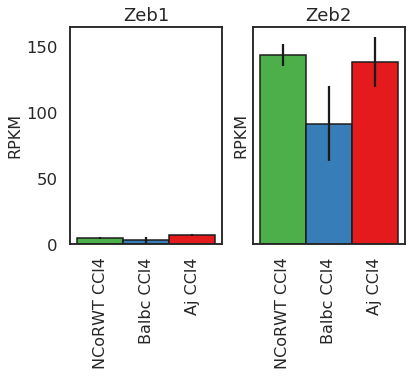

In [18]:
fig, axs = plt.subplots(1,2,figsize=(6,4), sharex=True, sharey=True)

count=0

for i in ['Zeb1', 'Zeb2']:
    survey_strain_ccl4_gene_exp(i, ax=axs.flatten()[count])
    count+=1

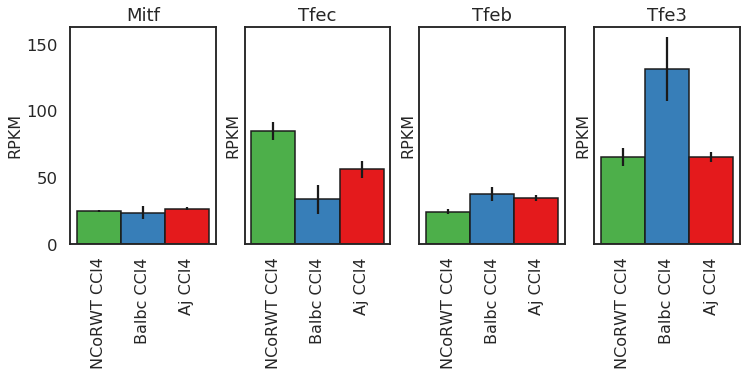

In [19]:
fig, axs = plt.subplots(1,4,figsize=(12,4), sharex=True, sharey=True)

count=0

for i in ['Mitf', 'Tfec', 'Tfeb', 'Tfe3']:
    survey_strain_ccl4_gene_exp(i, ax=axs.flatten()[count])
    count+=1

KeyError: 'Mzf2'

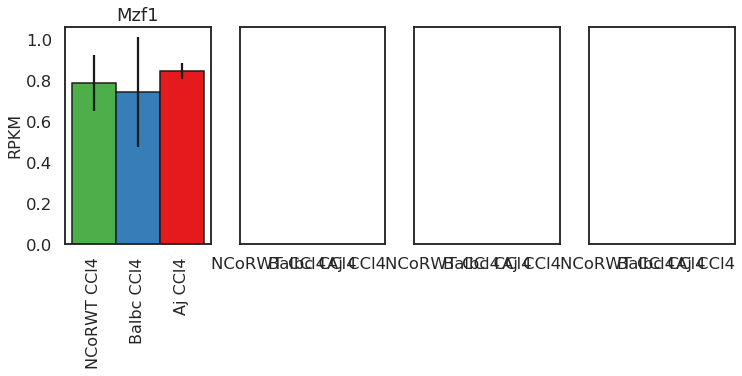

In [8]:
fig, axs = plt.subplots(1,4,figsize=(12,4), sharex=True, sharey=True)

count=0

for i in ['Mitf', 'Tfec', 'Tfeb', 'Tfe3']:
    survey_strain_ccl4_gene_exp(i, ax=axs.flatten()[count])
    count+=1